In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math

import keras
from keras.models import Sequential
from keras.layers import *
from keras_preprocessing.image import ImageDataGenerator

import zipfile 

import cv2
import seaborn as sns
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix

from keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Model

path = './data/challenges-in-representation-learning-facial-expression-recognition-challenge/'
os.listdir(path)

data = pd.read_csv(path+'icml_face_data.csv')
data.columns=['emotion','Usage','pixels']
train = pd.read_csv(path+'train.csv')
test=pd.read_csv(path+'test.csv')

data.head()

                    

,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [2]:
train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [3]:
test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


In [4]:
data['Usage'].value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

In [6]:
def prepare_data(data):
    image_array = np.zeros(shape=(len(data), 48, 48, 1))
    image_label = np.array(list(map(int, data['emotion'])))

    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48)) 
        image_array[i, :, :, 0] = image / 255

    return image_array, image_label

def vis_training(hlist, start=1):
    
    loss = np.concatenate([h.history['loss'] for h in hlist])
    val_loss = np.concatenate([h.history['val_loss'] for h in hlist])
    acc = np.concatenate([h.history['accuracy'] for h in hlist])
    val_acc = np.concatenate([h.history['val_accuracy'] for h in hlist])
    
    epoch_range = range(1,len(loss)+1)

    plt.figure(figsize=[12,6])
    plt.subplot(1,2,1)
    plt.plot(epoch_range[start-1:], loss[start-1:], label='Training Loss')
    plt.plot(epoch_range[start-1:], val_loss[start-1:], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epoch_range[start-1:], acc[start-1:], label='Training Accuracy')
    plt.plot(epoch_range[start-1:], val_acc[start-1:], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.show()

In [7]:
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 
            4: 'Sad', 5: 'Surprise', 6: 'Neutral'}

In [8]:
full_train_images, full_train_labels = prepare_data(data[data['Usage']=='Training'])
test_images, test_labels = prepare_data(data[data['Usage']!='Training'])

print(full_train_images.shape)
print(full_train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(28709, 48, 48, 1)
(28709,)
(7178, 48, 48, 1)
(7178,)


In [10]:
train_images, valid_images, train_labels, valid_lables = train_test_split(full_train_images, full_train_labels, test_size=0.2, random_state=1)

print(train_images.shape)
print(valid_images.shape)
print(train_labels.shape)
print(valid_lables.shape)

(22967, 48, 48, 1)
(5742, 48, 48, 1)
(22967,)
(5742,)


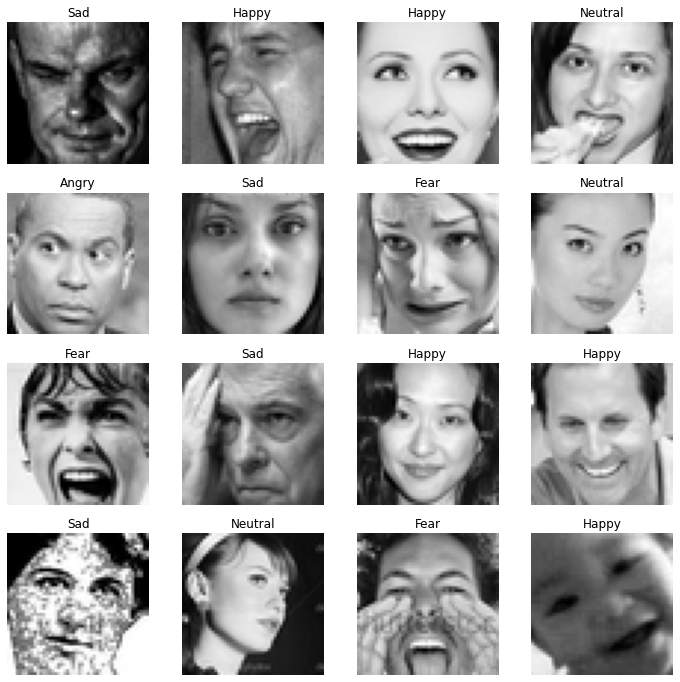

In [11]:
N_train = train_labels.shape[0]
sel = np.random.choice(range(N_train),replace=False,size=16)

X_sel = train_images[sel, :,:,:]
Y_sel = train_labels[sel]

plt.figure(figsize=[12,12])
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(X_sel[i,:,:,0],cmap='binary_r')
    plt.title(emotions[Y_sel[i]])
    plt.axis('off')
plt.show()

In [12]:
%%time

cnn = Sequential()

cnn.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same',
               input_shape=(48,48,1)))
cnn.add(Conv2D(128,kernel_size=(3,3),activation='relu',padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
cnn.add(Dropout(0.25))
cnn.add(BatchNormalization())

cnn.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same'))
cnn.add(Conv2D(256,kernel_size=(3,3),activation='relu',padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
cnn.add(Dropout(0.25))
cnn.add(BatchNormalization())

cnn.add(Conv2D(512, kernel_size=(3,3),activation='relu',padding='same'))
cnn.add(Conv2D(512,kernel_size=(3,3),activation='relu',padding='same'))
cnn.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
cnn.add(Dropout(0.5))
cnn.add(BatchNormalization())

cnn.add(Flatten())

cnn.add(Dense(512,activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(512,activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(512,activation='relu'))
cnn.add(Dropout(0.5))
cnn.add(Dense(512,activation='relu'))
cnn.add(Dropout(0.5))

cnn.add(Dense(7,activation='softmax'))
cnn.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 128)       1280      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 128)       147584    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 24, 24, 128)       512       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 256)       295168    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 256)       5

In [13]:
%%time

opt=keras.optimizers.Adam(lr=0.001)
cnn.compile(loss='sparse_categorical_crossentropy',optimizer=opt,
            metrics=['accuracy'])


Wall time: 8.98 ms


In [12]:
%%time

hypothesis1 = cnn.fit(train_images, train_labels, batch_size=256, epochs=30,
                      verbose=1, validation_data=(valid_images, valid_lables))


Epoch 1/30
90/90 [==============================] - 856s 10s/step - loss: 2.0640 - accuracy: 0.2015 - val_loss: 1.8212 - val_accuracy: 0.2560
Epoch 2/30
90/90 [==============================] - 855s 10s/step - loss: 1.8421 - accuracy: 0.2268 - val_loss: 1.8121 - val_accuracy: 0.2553
Epoch 3/30
90/90 [==============================] - 855s 10s/step - loss: 1.8112 - accuracy: 0.2431 - val_loss: 1.8030 - val_accuracy: 0.2564
Epoch 4/30
90/90 [==============================] - 854s 9s/step - loss: 1.7707 - accuracy: 0.2769 - val_loss: 1.8227 - val_accuracy: 0.2659
Epoch 5/30
90/90 [==============================] - 853s 9s/step - loss: 1.6842 - accuracy: 0.3222 - val_loss: 1.7407 - val_accuracy: 0.2985
Epoch 6/30
90/90 [==============================] - 852s 9s/step - loss: 1.6020 - accuracy: 0.3593 - val_loss: 1.7762 - val_accuracy: 0.2158
Epoch 7/30
90/90 [==============================] - 852s 9s/step - loss: 1.5076 - accuracy: 0.4080 - val_loss: 1.6505 - val_accuracy: 0.3497
Epoch 8/30

KeyboardInterrupt: 

In [ ]:
vis_training([hypothesis1])

In [30]:
### %%time 
keras.backend.set_value(cnn.optimizer.learning_rate, 0.00001)

h2 = cnn.fit(train_images, train_labels, batch_size=256, epochs=30, verbose=1, 
                   validation_data =(valid_images, valid_lables)) 

Epoch 1/30
90/90 [==============================] - 949s 11s/step - loss: 0.7630 - accuracy: 0.7206 - val_loss: 1.0220 - val_accuracy: 0.6311
Epoch 2/30
90/90 [==============================] - 884s 10s/step - loss: 0.7423 - accuracy: 0.7301 - val_loss: 1.0153 - val_accuracy: 0.6358
Epoch 3/30
90/90 [==============================] - 881s 10s/step - loss: 0.7386 - accuracy: 0.7289 - val_loss: 1.0128 - val_accuracy: 0.6357
Epoch 4/30
90/90 [==============================] - 890s 10s/step - loss: 0.7313 - accuracy: 0.7314 - val_loss: 1.0109 - val_accuracy: 0.6372
Epoch 5/30
90/90 [==============================] - 883s 10s/step - loss: 0.7238 - accuracy: 0.7316 - val_loss: 1.0098 - val_accuracy: 0.6376
Epoch 6/30
90/90 [==============================] - 880s 10s/step - loss: 0.7178 - accuracy: 0.7361 - val_loss: 1.0083 - val_accuracy: 0.6372
Epoch 7/30
90/90 [==============================] - 881s 10s/step - loss: 0.7149 - accuracy: 0.7393 - val_loss: 1.0082 - val_accuracy: 0.6367
Epoch 

In [ ]:
vis_training([hypothesis1, h2])

In [16]:
cnn.save('final_model.h5')

In [25]:
test_prob = cnn.predict(test_images)
test_pred = np.argmax(test_prob, axis=1)
test_accuracy = np.mean(test_pred == test_labels)

print('accuracy: ',test_accuracy)

accuracy:  0.6161883533017554


In [24]:
conf_mat = confusion_matrix(test_labels, test_pred)

pd.DataFrame(conf_mat, columns=emotions.values(), index=emotions.values())

,Angry,Disgust,Fear,Happy,Sad,Surprise,Neutral
Angry,540,9,73,44,179,17,96
Disgust,42,46,10,3,10,0,0
Fear,132,6,348,42,305,88,103
Happy,32,0,28,1528,60,33,93
Sad,124,7,84,64,748,16,204
Surprise,18,1,91,38,15,634,34
Neutral,68,1,43,74,261,11,775


<ipython-input-25-45440dedc879>:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


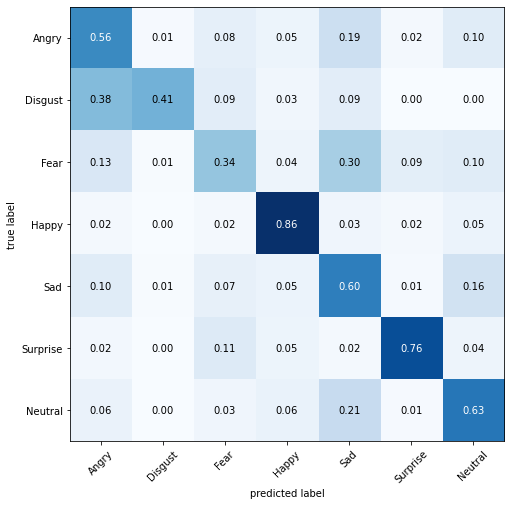

In [25]:
fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                class_names=emotions.values(),
                                figsize=(8, 8))
fig.show()

In [ ]:
print(classification_report(test_labels, test_pred, target_names=emotions.values()))

In [15]:
cnn.load_weights('final_model.h5')
print(cnn.weights[0])

<tf.Variable 'conv2d/kernel:0' shape=(3, 3, 1, 128) dtype=float32, numpy=
array([[[[-0.0227582 , -0.00655361,  0.1234642 , ..., -0.10360192,
          -0.0559524 ,  0.04406343]],

        [[ 0.03236406, -0.09846764,  0.10302165, ...,  0.01018215,
           0.00288611, -0.02932744]],

        [[ 0.07799655, -0.05959614, -0.05636076, ...,  0.04502305,
           0.07634035, -0.00123327]]],


       [[[-0.05145344, -0.10864013, -0.1420524 , ..., -0.12747332,
          -0.05800552, -0.03589439]],

        [[-0.07847422,  0.10275117,  0.05223102, ...,  0.05894255,
           0.06379809,  0.04273393]],

        [[-0.05178808,  0.00871226, -0.10867414, ...,  0.14446926,
           0.09176988, -0.06985581]]],


       [[[-0.02847982, -0.13143678, -0.08645478, ..., -0.07625568,
          -0.05496187, -0.00862741]],

        [[ 0.01408075,  0.01780258,  0.04883723, ...,  0.08295714,
          -0.07455672, -0.00430553]],

        [[-0.04450152, -0.00137239,  0.08965685, ...,  0.0390319 ,
       

[0 1 2 3 4 5 6]
[1.03729926e-01 1.75810797e-04 6.31066859e-02 1.17797650e-01
 2.27115199e-01 3.82621703e-03 4.84248519e-01]


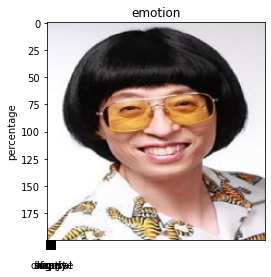

Expression Prediction: neutral


In [29]:
from skimage import io
from keras_preprocessing import image
import matplotlib.pyplot as plt

objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
y_pos = np.arange(len(objects))
print(y_pos)

def emotion_analysis(emotions):
    objects = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
    y_pos = np.arange(len(objects))
    plt.bar(y_pos, emotions, align='center', alpha=0.9)
    plt.tick_params(axis='x', which='both', pad=10,width=4,length=10)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    
plt.show()

#y_pred=cnn.predict(test_images)
#print(y_pred)
#print(y_pred.shape)

img = image.load_img('./h2.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('./h2.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = cnn.predict(x)
print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48])

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:', objects[ind])

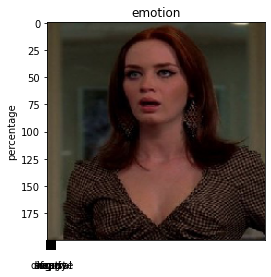

Expression Prediction: sad


In [31]:
from skimage import io
img = image.load_img('./surprised.jpg', grayscale=True, target_size=(48, 48))
show_img=image.load_img('./surprised.jpg', grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255

custom = cnn.predict(x)
#print(custom[0])
emotion_analysis(custom[0])

x = np.array(x, 'float32')
x = x.reshape([48, 48])

plt.gray()
plt.imshow(show_img)
plt.show()

m=0.000000000000000000001
a=custom[0]
for i in range(0,len(a)):
    if a[i]>m:
        m=a[i]
        ind=i
        
print('Expression Prediction:',objects[ind])

In [37]:
from keras.models import load_model, save_model

loaded_model = load_model('final_model.h5')

train_predicted = np.argmax(cnn.predict(X_sel),axis=1)

failed_Index = []

for i in range(len(train_predicted)):
    if (train_predicted[i]) != Y_sel[i]:
       failed_Index.append(i)

len(failed_Index)

5

2
4


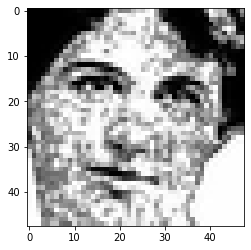

In [42]:
idx = failed_Index[3]
print(Y_sel[idx])

# objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')

plt.imshow(X_sel[idx][:,:,0],cmap='gray')

idx = failed_Index[4]
print(Y_sel[idx])

plt.imshow(X_sel[idx][:,:,0],cmap='gray')